In [1]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.autograd import Variable
print(torch.__version__)

1.1.0


### Dataset Class (loads data from csv)

In [3]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (5, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(128100, 8)
(16050, 8)
(16050, 8)


### Dataloader definitions (provides data in iterable form)

In [87]:
train_batch_size = 8
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

# signal, label = next(iter(trainloader))
# print(signal.shape)
# print(label.shape)

Function for calculating output size for given input size, filter size, padding and stride for a CNN

In [8]:
def output_size(n, f, p = 0, s = 1):
    return (((n + 2 * p - f) / s) + 1)

output_size(150, 3)
output_size(148, 3)

146.0

In [107]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
#         self.conv1 = nn.Conv1d(3, 10, 3)
#         self.conv2 = nn.Conv1d(10, 15, 3)
#         self.conv3 = nn.Conv1d(15, 20, 3)
        self.fc1 = nn.Linear(150 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)
        
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc3.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal = signal.view(-1, 150 * 3)
        out = F.relu(self.fc1(signal))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [108]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3, weight_decay = 1e-1)

In [109]:
num_epochs = 20
total_step = len(trainset) // train_batch_size
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '2conv_softmax.pt')

epoch =  0  step =  0  of total steps  16012  loss =  1.7440937757492065
epoch =  0  step =  20  of total steps  16012  loss =  1.388783574104309
epoch =  0  step =  40  of total steps  16012  loss =  1.5119402408599854
epoch =  0  step =  60  of total steps  16012  loss =  1.497506856918335
epoch =  0  step =  80  of total steps  16012  loss =  1.5476007461547852
epoch =  0  step =  100  of total steps  16012  loss =  1.4727420806884766
epoch :  0  /  20  | TL :  1.5255412245696445  | VL :  1.530864953994751
saving model
epoch =  1  step =  0  of total steps  16012  loss =  1.5372083187103271
epoch =  1  step =  20  of total steps  16012  loss =  1.3468658924102783
epoch =  1  step =  40  of total steps  16012  loss =  1.5341323614120483
epoch =  1  step =  60  of total steps  16012  loss =  1.5024219751358032
epoch =  1  step =  80  of total steps  16012  loss =  1.438321590423584
epoch =  1  step =  100  of total steps  16012  loss =  1.5530476570129395
epoch :  1  /  20  | TL :  1.

epoch =  15  step =  100  of total steps  16012  loss =  1.662811040878296
epoch :  15  /  20  | TL :  1.5143744473187428  | VL :  1.525626540184021
epoch =  16  step =  0  of total steps  16012  loss =  1.6300100088119507
epoch =  16  step =  20  of total steps  16012  loss =  1.3399255275726318
epoch =  16  step =  40  of total steps  16012  loss =  1.5294454097747803
epoch =  16  step =  60  of total steps  16012  loss =  1.5600128173828125
epoch =  16  step =  80  of total steps  16012  loss =  1.3406175374984741
epoch =  16  step =  100  of total steps  16012  loss =  1.3808459043502808
epoch :  16  /  20  | TL :  1.513566330918726  | VL :  1.5290355682373047
epoch =  17  step =  0  of total steps  16012  loss =  1.394396185874939
epoch =  17  step =  20  of total steps  16012  loss =  1.5891327857971191
epoch =  17  step =  40  of total steps  16012  loss =  1.5195121765136719
epoch =  17  step =  60  of total steps  16012  loss =  1.4190921783447266
epoch =  17  step =  80  of t

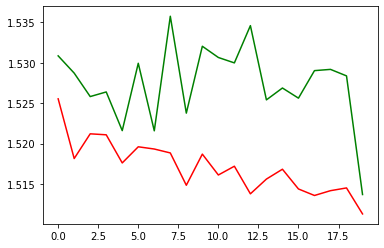

In [110]:
j = np.arange(20)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [111]:
def _get_accuracy(dataloader):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net.cpu()
# _get_accuracy(trainloader)

ConvNet(
  (fc1): Linear(in_features=450, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)

In [112]:
print(_get_accuracy(trainloader))
print(_get_accuracy(testloader))
print(_get_accuracy(valloader))

0.38207547169811323
0.41346153846153844
0.3557692307692308


Directly training NNs on raw data doesn't work well. So, we can try to use some pre-processing to the data before training (like running mean, running std deviation, running rms, etc.)